In [99]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [100]:
MIN_LOOKBACK = max([
    21,  # EMA
    52,  # Ichimoku
    14,  # RSI
    14,  # Stochastic
    26,  # MACD
    20,  # Donchian
    20   # CMF
])

In [101]:
df = pd.read_csv("../data/coinbaseUSD_1-min_data.csv", header=0)

df['Date'] = pd.to_datetime(df['Date'])

df = df[-100000:]
# Set 'Date' as the index
df.set_index('Date', inplace=True)
df = df.drop(['Symbol', 'Unix Timestamp'], axis=1)
df.rename(columns={
    "Open":"open",
    "High":"high",
    "Low":"low",
    "Close":"close",
    "Volume":"volume"
}, inplace=True)



In [102]:
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)

In [103]:
# Technical indicators
df["VWAP"] = ta.vwap(df.high, df.low, df.close, df.volume)
df['RSI'] = ta.rsi(df.close, length=16)
df['RSI_8MIN'] = ta.rsi(df.close, length=8)
# my_bbands = ta.bbands(df.close, length=14, std=2.0)
macd = ta.macd(df.close)

# test_data = df[-55:]
# df = df[50:-55]

C:\Users\Pc\AppData\Local\Temp\ipykernel_13332\351530010.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["VWAP"] = ta.vwap(df.high, df.low, df.close, df.volume)


In [104]:
df = pd.concat([df, macd], axis=1)

                   open      high       low     close    volume      VWAP  \
open           1.000000  0.999975  0.999971  0.999956 -0.067139  0.994400   
high           0.999975  1.000000  0.999955  0.999977 -0.064231  0.994402   
low            0.999971  0.999955  1.000000  0.999976 -0.070841  0.994318   
close          0.999956  0.999977  0.999976  1.000000 -0.067528  0.994364   
volume        -0.067139 -0.064231 -0.070841 -0.067528  1.000000 -0.062438   
VWAP           0.994400  0.994402  0.994318  0.994364 -0.062438  1.000000   
RSI            0.012618  0.014095  0.014586  0.015591 -0.021809 -0.018604   
RSI_8MIN       0.008702  0.010649  0.011022  0.012532 -0.017664 -0.011367   
MACD_12_26_9   0.020421  0.020385  0.021462  0.021035 -0.069956 -0.024385   
MACDh_12_26_9 -0.001023 -0.000223  0.000160  0.000720 -0.021907 -0.003635   
MACDs_12_26_9  0.021947  0.021651  0.022672  0.022039 -0.067298 -0.024837   

                    RSI  RSI_8MIN  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26

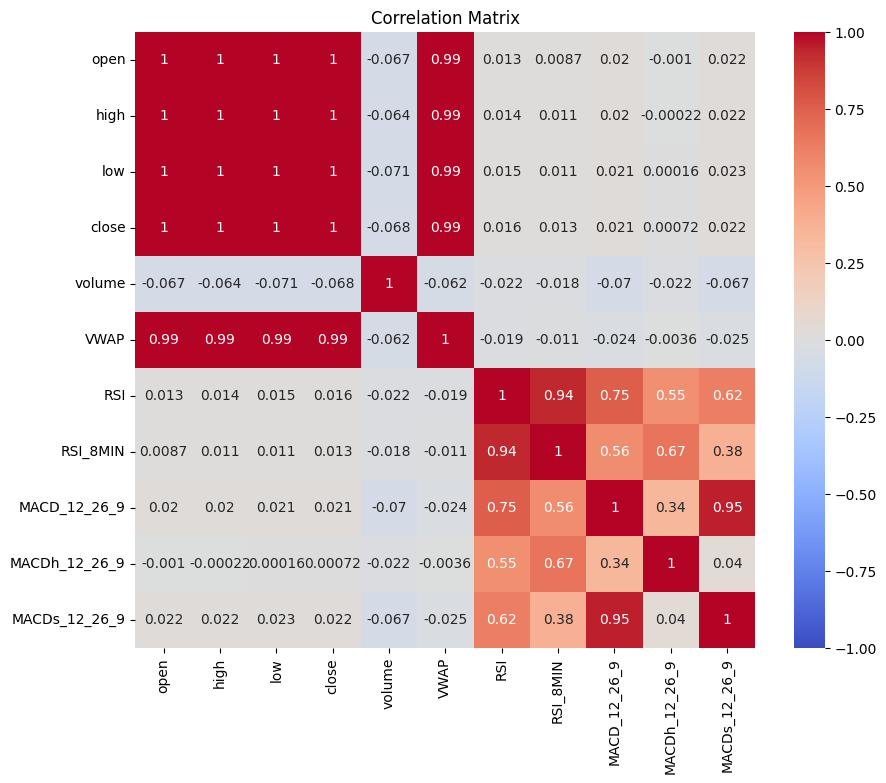

In [105]:
correlation_matrix = df[df.columns].corr()

# Create a heatmap of the correlation matrix
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [106]:
# Calculate Ichimoku indicators
ichimoku_visible, ichimoku_forward = df.ta.ichimoku(high=df['high'], low=df['low'], close=df['close'], tenkan=7, kijun=22, senkou=44)

# Add relevant Ichimoku columns from the 'visible' DataFrame to your main DataFrame
df['tenkan_sen'] = ichimoku_visible['ISA_7']
df['kijun_sen'] = ichimoku_visible['ISB_22']
df['span_a'] = ichimoku_visible['ITS_7']
df['span_b'] = ichimoku_visible['IKS_22']
df['chikou_span'] = ichimoku_visible['ICS_22']

In [ ]:
# last_timestamp = df_temp.index[-1]
# forward_timestamps = pd.date_range(start=pd.to_datetime(last_timestamp, unit='s'), 
#                                  periods=len(ichimoku_forward),
#                                  freq='1min')

# # Set proper index for forward values
# ichimoku_forward.index = forward_timestamps

In [107]:
df.head()

,open,high,low,close,volume,VWAP,RSI,RSI_8MIN,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,tenkan_sen,kijun_sen,span_a,span_b,chikou_span
Date,,,,,,,,,,,,,,,,
2024-05-21 06:21:00+00:00,71089.71,71153.75,71089.71,71153.75,4.900671,71132.403333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71366.91
2024-05-21 06:22:00+00:00,71153.75,71192.19,71152.42,71192.18,4.749921,71155.303275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71328.48
2024-05-21 06:23:00+00:00,71192.19,71242.46,71189.27,71193.15,11.620343,71184.251822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71331.72
2024-05-21 06:24:00+00:00,71193.66,71202.80,71138.44,71183.10,8.889186,71181.460162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71300.01
2024-05-21 06:25:00+00:00,71183.09,71209.05,71170.96,71197.70,6.446220,71183.416557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71269.47


In [108]:
def feature_engineering(df):
    # Видалення високо корельованих змінних
    
    # Створення нових ознак
    df['hl_range'] = df['high'] - df['low']
    df['oc_range'] = df['open'] - df['close']

    df['RSI_diff'] = df['RSI_8MIN'] - df['RSI']
    
    # Bollinger Bands
    # df['bb_width'] = (df['BBU_14_2.0'] - df['BBL_14_2.0']) / df['BBM_14_2.0']
    # df['bb_position'] = (df['close'] - df['BBL_14_2.0']) / (df['BBU_14_2.0'] - df['BBL_14_2.0'])
    
    # Логарифмічні різниці
    # df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    # df['log_volume_change'] = np.log(df['volume'] / df['volume'].shift(1))
        
    df['close_vwap_ratio'] = df['close'] / df['VWAP'] - 1
    
    # Зміна VWAP
    df['vwap_change'] = df['VWAP'].pct_change()
                   
    # Обчислення SMA та EMA
    df['SMA_10'] = df['close'].rolling(window=7).mean()
    df['EMA_5'] = df['close'].ewm(span=4, adjust=False).mean()
    
    # Відносне положення ціни закриття між SMA та EMA
    df['close_between_ma'] = (df['close'] - df['SMA_10']) / (df['EMA_5'] - df['SMA_10'])
    
    # Різниця між EMA та SMA
    df['ema_sma_diff'] = df['EMA_5'] - df['SMA_10']
            
    # Нахил SMA та EMA
    # df['sma_slope'] = (df['SMA_10'] - df['SMA_10'].shift(1)) / df['SMA_10'].shift(1)
    # df['ema_slope'] = (df['EMA_5'] - df['EMA_5'].shift(1)) / df['EMA_5'].shift(1)

    # Ichimoku differences
    df['ichimoku_tenkan_kijun_diff'] = df['tenkan_sen'] - df['kijun_sen']
     
    df = df.drop(['EMA_5', 'SMA_10', 'VWAP','high', 'open', 'low', 'close', 'tenkan_sen', 'kijun_sen', 'span_a', 'span_b', 'chikou_span', 'RSI', 'MACD_12_26_9', 'MACDs_12_26_9'], axis=1)
    



    return df

In [109]:
df_engineered = feature_engineering(df)

In [110]:
df_engineered[-10:]

,volume,RSI_8MIN,MACDh_12_26_9,hl_range,oc_range,RSI_diff,close_vwap_ratio,vwap_change,close_between_ma,ema_sma_diff,ichimoku_tenkan_kijun_diff
Date,,,,,,,,,,,
2024-07-29 17:58:00+00:00,11.435727,51.048984,-8.225949,71.53,4.78,-1.309252,-0.022768,-0.000023,0.388219,-12.040346,68.5875
2024-07-29 17:59:00+00:00,17.055683,48.055042,-9.052847,77.04,24.26,-2.953967,-0.022992,-0.000035,2.420139,-4.353351,76.1700
2024-07-29 18:00:00+00:00,28.208585,39.870082,-12.826454,118.10,51.33,-7.178042,-0.023724,-0.000059,3.898818,-12.481439,94.4550
2024-07-29 18:01:00+00:00,35.571038,66.516058,-0.646478,278.14,-217.09,6.073422,-0.020431,-0.000068,3.491053,44.575994,101.6075
2024-07-29 18:02:00+00:00,11.814024,58.823594,3.130313,97.79,57.52,2.317802,-0.021242,-0.000022,1.667782,48.439025,105.2075
2024-07-29 18:03:00+00:00,16.786577,67.679662,12.639496,166.88,-118.43,5.697916,-0.019486,-0.000030,2.334744,67.782272,93.4025
2024-07-29 18:04:00+00:00,14.302211,67.779296,17.750862,54.19,-1.50,5.733428,-0.019440,-0.000024,1.736791,74.888506,93.4025
2024-07-29 18:05:00+00:00,12.772139,69.423356,21.153482,83.58,-22.75,6.363248,-0.019087,-0.000022,1.644975,72.483961,93.4025
2024-07-29 18:06:00+00:00,16.879374,69.496104,21.866646,69.59,-2.28,6.392984,-0.019045,-0.000028,1.517070,55.327519,93.4025


                              volume  RSI_8MIN  MACDh_12_26_9  hl_range  \
volume                      1.000000 -0.017664      -0.021907  0.696730   
RSI_8MIN                   -0.017664  1.000000       0.671140 -0.040072   
MACDh_12_26_9              -0.021907  0.671140       1.000000 -0.039847   
hl_range                    0.696730 -0.040072      -0.039847  1.000000   
oc_range                    0.041386 -0.407655      -0.185574  0.028467   
RSI_diff                   -0.006029  0.823282       0.672215 -0.008400   
close_vwap_ratio           -0.044975  0.221709       0.040948 -0.082487   
vwap_change                -0.016637  0.058355       0.045726 -0.024342   
close_between_ma           -0.000143 -0.003782      -0.000373 -0.001495   
ema_sma_diff               -0.044678  0.712313       0.696111 -0.064907   
ichimoku_tenkan_kijun_diff -0.016951 -0.026388      -0.296396 -0.041620   

                            oc_range  RSI_diff  close_vwap_ratio  vwap_change  \
volume            

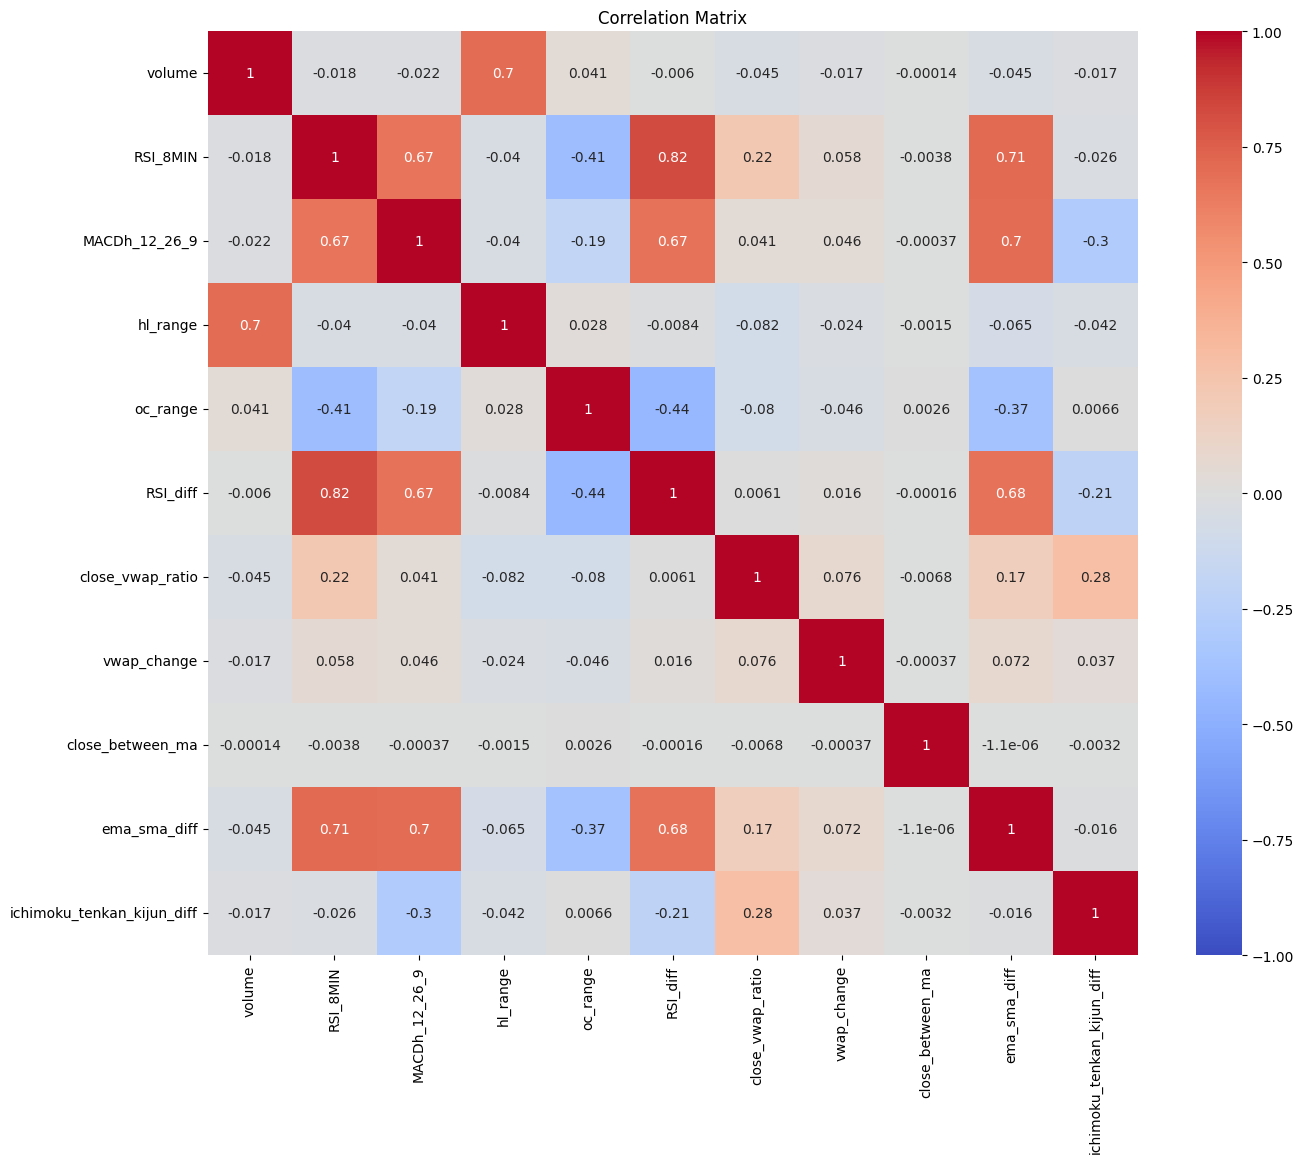

In [111]:
correlation_matrix = df_engineered[df_engineered.columns].corr()

# Create a heatmap of the correlation matrix
print(correlation_matrix)
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [112]:
df_engineered.describe()

,volume,RSI_8MIN,MACDh_12_26_9,hl_range,oc_range,RSI_diff,close_vwap_ratio,vwap_change,close_between_ma,ema_sma_diff,ichimoku_tenkan_kijun_diff
count,100000.000000,99992.000000,99967.000000,100000.000000,100000.000000,99984.000000,100000.000000,9.999900e+04,99994.000000,99994.000000,99935.000000
mean,6.981325,50.150634,0.000769,46.041329,-0.090127,0.021762,-0.000155,-3.383944e-07,1.933090,-0.059220,1.502563
std,12.866107,15.063231,13.033486,40.200398,39.369563,6.476708,0.007044,2.440998e-04,149.707908,26.287658,90.693234
min,0.002111,2.257521,-163.002888,0.010000,-1149.320000,-20.384138,-0.039997,-2.327276e-02,-32807.943757,-385.964863,-651.017500
25%,1.402269,39.398954,-6.119058,21.960000,-17.840000,-4.694683,-0.003459,-4.039838e-06,1.256127,-11.638476,-42.445000
50%,3.282211,50.027797,-0.055614,36.830000,-0.010000,0.019082,0.000132,9.569919e-08,1.891982,0.060891,0.305000
75%,7.659579,60.844427,5.993134,58.390000,17.520000,4.747823,0.003203,4.039177e-06,2.558602,11.935573,44.585000
max,646.158688,97.493956,155.863027,1298.610000,697.820000,21.286409,0.046877,2.749341e-02,21563.053897,423.555820,809.870000


In [113]:

df_numeric = df_engineered.select_dtypes(include=[np.number])

# Define a scaler for features (all columns)
feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = feature_scaler.fit_transform(df_numeric)

In [114]:
scaled_data = scaled_data[100:]

In [115]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Припустимо, що у вас є датасет з 7 ознак, включаючи "close"
seq_length = 50
pred_length = 5

# Створюємо функцію для підготовки послідовностей
def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data[i:i+seq_length])  # 50 рядків для навчання
        y.append(data[i+seq_length:i+seq_length+pred_length, 3])  # Прогнозуємо "close" (індекс 3)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, seq_length, pred_length)

# Кастомна функція втрат (MSE між двома векторами з 5 елементів)
def custom_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    return mse

# Створюємо модель LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(pred_length)  # Передбачаємо 5 наступних значень "close"
])

# Використовуємо кастомну функцію втрат
model.compile(optimizer='adam', loss=custom_loss)

# Навчання моделі
history = model.fit(X, y, epochs=10, batch_size=32)

# Прогнозуємо на останньому вікні і можемо перевірити на реальних даних
last_sequence = X[-1]  # Беремо останні 50 кроків
predicted_close = model.predict(last_sequence[np.newaxis, :, :])
predicted_close = scaler.inverse_transform(predicted_close)  # Масштабуємо назад

# Виводимо результати
print("Прогнозовані 5 значень 'close':", predicted_close)
print("Реальні 5 значень 'close':", df[-5:, 3])

Epoch 1/10
 743/3121 [======>.......................] - ETA: 31s - loss: 8.6742e-04

KeyboardInterrupt: 